In [ ]:
!pip install huggingface_hub datasets matplotlib numpy pillow wandb albumentations timm

  Using cached huggingface_hub-0.20.3-py3-none-any.whl.metadata (12 kB)
  Using cached datasets-2.17.1-py3-none-any.whl.metadata (20 kB)
  Using cached matplotlib-3.8.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.8 kB)
  Using cached wandb-0.16.3-py3-none-any.whl.metadata (9.9 kB)
  Using cached albumentations-1.4.0-py3-none-any.whl.metadata (35 kB)
  Using cached fsspec-2024.2.0-py3-none-any.whl.metadata (6.8 kB)
  Using cached pyarrow-15.0.0-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (3.0 kB)
  Using cached pyarrow_hotfix-0.6-py3-none-any.whl.metadata (3.6 kB)
  Using cached dill-0.3.8-py3-none-any.whl.metadata (10 kB)
  Using cached pandas-2.2.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (19 kB)
  Using cached xxhash-3.4.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (12 kB)
  Using cached multiprocess-0.70.16-py311-none-any.whl.metadata (7.2 kB)
  Using cached fsspec-2023.10.0-py3-none-any.whl.metadata (

In [1]:
import torch
import torch.nn as nn
import random
import numpy as np

def set_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

# Set all seeds
set_seeds(42)

In [2]:
import torch
from torch import nn
import torch.nn.functional as F

from timm.models.layers import trunc_normal_
import math


class DepthWiseConv2d(nn.Module):
    def __init__(self, dim_in, dim_out, kernel_size=3, padding=1, stride=1, dilation=1):
        super().__init__()
        
        self.conv1 = nn.Conv2d(dim_in, dim_in, kernel_size=kernel_size, padding=padding, 
                      stride=stride, dilation=dilation, groups=dim_in)
        self.norm_layer = nn.GroupNorm(4, dim_in)
        self.conv2 = nn.Conv2d(dim_in, dim_out, kernel_size=1)

    def forward(self, x):
        return self.conv2(self.norm_layer(self.conv1(x)))

class GatedAttentionUnit(nn.Module):
    def __init__(self, in_c, out_c, kernel_size):
        super().__init__()
        self.w1 = nn.Sequential(
            DepthWiseConv2d(in_c, in_c, kernel_size, padding=kernel_size//2),
            nn.Sigmoid()
        )
        
        self.w2 = nn.Sequential(
            DepthWiseConv2d(in_c, in_c, kernel_size + 2, padding=(kernel_size + 2)//2),
            nn.GELU()
        )
        self.wo = nn.Sequential(
            DepthWiseConv2d(in_c, out_c, kernel_size),
            nn.GELU()
        )
        
        self.cw = nn.Conv2d(in_c, out_c, 1)
        
    def forward(self, x):
        x1, x2 = self.w1(x), self.w2(x)
        out = self.wo(x1 * x2) + self.cw(x)
        return out


class DilatedGatedAttention(nn.Module):
    def __init__(self, in_c, out_c, k_size=3, dilated_ratio=[7, 5, 2, 1]):
        super().__init__()        
        
        self.mda0 = nn.Conv2d(in_c//4, in_c//4, kernel_size=k_size, stride=1, 
                              padding=(k_size+(k_size-1)*(dilated_ratio[0]-1))//2, 
                             dilation=dilated_ratio[0], groups=in_c//4)
        self.mda1 = nn.Conv2d(in_c//4, in_c//4, kernel_size=k_size, stride=1, 
                              padding=(k_size+(k_size-1)*(dilated_ratio[1]-1))//2, 
                             dilation=dilated_ratio[1], groups=in_c//4)
        self.mda2 = nn.Conv2d(in_c//4, in_c//4, kernel_size=k_size, stride=1, 
                              padding=(k_size+(k_size-1)*(dilated_ratio[2]-1))//2, 
                             dilation=dilated_ratio[2], groups=in_c//4)
        self.mda3 = nn.Conv2d(in_c//4, in_c//4, kernel_size=k_size, stride=1, 
                              padding=(k_size+(k_size-1)*(dilated_ratio[3]-1))//2, 
                             dilation=dilated_ratio[3], groups=in_c//4)
        self.norm_layer = nn.GroupNorm(4, in_c)
        self.conv = nn.Conv2d(in_c, in_c, 1)
        
        self.gau = GatedAttentionUnit(in_c, out_c, 3)
        
    def forward(self, x):
        x = torch.chunk(x, 4, dim=1)
        x0 = self.mda0(x[0])
        x1 = self.mda1(x[1])
        x2 = self.mda2(x[2])
        x3 = self.mda3(x[3])
        x = F.gelu(self.conv(self.norm_layer(torch.cat((x0, x1, x2, x3), dim=1))))
        x = self.gau(x)
        return x
    
    
class EAblock(nn.Module):
    def __init__(self, in_c):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_c, in_c, 1)

        self.k = in_c * 4
        self.linear_0 = nn.Conv1d(in_c, self.k, 1, bias=False)

        self.linear_1 = nn.Conv1d(self.k, in_c, 1, bias=False)
        self.linear_1.weight.data = self.linear_0.weight.data.permute(1, 0, 2)        
        
        self.conv2 = nn.Conv2d(in_c, in_c, 1, bias=False)
        self.norm_layer = nn.GroupNorm(4, in_c)   

    def forward(self, x):
        idn = x
        x = self.conv1(x)

        b, c, h, w = x.size()
        x = x.view(b, c, h*w)   # b * c * n 

        attn = self.linear_0(x) # b, k, n
        attn = F.softmax(attn, dim=-1) # b, k, n

        attn = attn / (1e-9 + attn.sum(dim=1, keepdim=True)) #  # b, k, n
        x = self.linear_1(attn) # b, c, n

        x = x.view(b, c, h, w)
        x = self.norm_layer(self.conv2(x))
        x = x + idn
        x = F.gelu(x)
        return x
    

class Channel_Att_Bridge(nn.Module):
    def __init__(self, c_list, split_att='fc'):
        super().__init__()
        c_list_sum = sum(c_list) - c_list[-1]
        self.split_att = split_att
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.get_all_att = nn.Conv1d(1, 1, kernel_size=3, padding=1, bias=False)
        self.att1 = nn.Linear(c_list_sum, c_list[0]) if split_att == 'fc' else nn.Conv1d(c_list_sum, c_list[0], 1)
        self.att2 = nn.Linear(c_list_sum, c_list[1]) if split_att == 'fc' else nn.Conv1d(c_list_sum, c_list[1], 1)
        self.att3 = nn.Linear(c_list_sum, c_list[2]) if split_att == 'fc' else nn.Conv1d(c_list_sum, c_list[2], 1)
        self.att4 = nn.Linear(c_list_sum, c_list[3]) if split_att == 'fc' else nn.Conv1d(c_list_sum, c_list[3], 1)
        self.att5 = nn.Linear(c_list_sum, c_list[4]) if split_att == 'fc' else nn.Conv1d(c_list_sum, c_list[4], 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, t1, t2, t3, t4, t5):
        att = torch.cat((self.avgpool(t1), 
                         self.avgpool(t2), 
                         self.avgpool(t3), 
                         self.avgpool(t4), 
                         self.avgpool(t5)), dim=1)
        att = self.get_all_att(att.squeeze(-1).transpose(-1, -2))
        if self.split_att != 'fc':
            att = att.transpose(-1, -2)
        att1 = self.sigmoid(self.att1(att))
        att2 = self.sigmoid(self.att2(att))
        att3 = self.sigmoid(self.att3(att))
        att4 = self.sigmoid(self.att4(att))
        att5 = self.sigmoid(self.att5(att))
        if self.split_att == 'fc':
            att1 = att1.transpose(-1, -2).unsqueeze(-1).expand_as(t1)
            att2 = att2.transpose(-1, -2).unsqueeze(-1).expand_as(t2)
            att3 = att3.transpose(-1, -2).unsqueeze(-1).expand_as(t3)
            att4 = att4.transpose(-1, -2).unsqueeze(-1).expand_as(t4)
            att5 = att5.transpose(-1, -2).unsqueeze(-1).expand_as(t5)
        else:
            att1 = att1.unsqueeze(-1).expand_as(t1)
            att2 = att2.unsqueeze(-1).expand_as(t2)
            att3 = att3.unsqueeze(-1).expand_as(t3)
            att4 = att4.unsqueeze(-1).expand_as(t4)
            att5 = att5.unsqueeze(-1).expand_as(t5)
            
        return att1, att2, att3, att4, att5
    
    
class Spatial_Att_Bridge(nn.Module):
    def __init__(self):
        super().__init__()
        self.shared_conv2d = nn.Sequential(nn.Conv2d(2, 1, 7, stride=1, padding=9, dilation=3),
                                          nn.Sigmoid())
    
    def forward(self, t1, t2, t3, t4, t5):
        t_list = [t1, t2, t3, t4, t5]
        att_list = []
        for t in t_list:
            avg_out = torch.mean(t, dim=1, keepdim=True)
            max_out, _ = torch.max(t, dim=1, keepdim=True)
            att = torch.cat([avg_out, max_out], dim=1)
            att = self.shared_conv2d(att)
            att_list.append(att)
        return att_list[0], att_list[1], att_list[2], att_list[3], att_list[4]

    
class SC_Att_Bridge(nn.Module):
    def __init__(self, c_list, split_att='fc'):
        super().__init__()
        
        self.catt = Channel_Att_Bridge(c_list, split_att=split_att)
        self.satt = Spatial_Att_Bridge()
        
    def forward(self, t1, t2, t3, t4, t5):
        r1, r2, r3, r4, r5 = t1, t2, t3, t4, t5

        satt1, satt2, satt3, satt4, satt5 = self.satt(t1, t2, t3, t4, t5)
        t1, t2, t3, t4, t5 = satt1 * t1, satt2 * t2, satt3 * t3, satt4 * t4, satt5 * t5

        r1_, r2_, r3_, r4_, r5_ = t1, t2, t3, t4, t5
        t1, t2, t3, t4, t5 = t1 + r1, t2 + r2, t3 + r3, t4 + r4, t5 + r5

        catt1, catt2, catt3, catt4, catt5 = self.catt(t1, t2, t3, t4, t5)
        t1, t2, t3, t4, t5 = catt1 * t1, catt2 * t2, catt3 * t3, catt4 * t4, catt5 * t5

        return t1 + r1_, t2 + r2_, t3 + r3_, t4 + r4_, t5 + r5_
    
    
class MALUNet(nn.Module):
    
    def __init__(self, num_classes=1, input_channels=3, c_list=[8,16,24,32,48,64], 
                split_att='fc', bridge=True):
        super().__init__()

        self.bridge = bridge
        
        self.encoder1 = nn.Sequential(
            nn.Conv2d(input_channels, c_list[0], 3, stride=1, padding=1),
        )
        self.encoder2 =nn.Sequential(
            nn.Conv2d(c_list[0], c_list[1], 3, stride=1, padding=1),
        ) 
        self.encoder3 = nn.Sequential(
            nn.Conv2d(c_list[1], c_list[2], 3, stride=1, padding=1),
        )
        self.encoder4 = nn.Sequential(
            EAblock(c_list[2]),
            DilatedGatedAttention(c_list[2], c_list[3]),
        )
        self.encoder5 = nn.Sequential(
            EAblock(c_list[3]),
            DilatedGatedAttention(c_list[3], c_list[4]),
        )
        self.encoder6 = nn.Sequential(
            EAblock(c_list[4]),
            DilatedGatedAttention(c_list[4], c_list[5]),
        )

        if bridge: 
            self.scab = SC_Att_Bridge(c_list, split_att)
            print('SC_Att_Bridge was used')
        
        self.decoder1 = nn.Sequential(
            DilatedGatedAttention(c_list[5], c_list[4]),
            EAblock(c_list[4]),
        ) 
        self.decoder2 = nn.Sequential(
            DilatedGatedAttention(c_list[4], c_list[3]),
            EAblock(c_list[3]),
        ) 
        self.decoder3 = nn.Sequential(
            DilatedGatedAttention(c_list[3], c_list[2]),
            EAblock(c_list[2]),
        )  
        self.decoder4 = nn.Sequential(
            nn.Conv2d(c_list[2], c_list[1], 3, stride=1, padding=1),
        )  
        self.decoder5 = nn.Sequential(
            nn.Conv2d(c_list[1], c_list[0], 3, stride=1, padding=1),
        )  
        self.ebn1 = nn.GroupNorm(4, c_list[0])
        self.ebn2 = nn.GroupNorm(4, c_list[1])
        self.ebn3 = nn.GroupNorm(4, c_list[2])
        self.ebn4 = nn.GroupNorm(4, c_list[3])
        self.ebn5 = nn.GroupNorm(4, c_list[4])
        self.dbn1 = nn.GroupNorm(4, c_list[4])
        self.dbn2 = nn.GroupNorm(4, c_list[3])
        self.dbn3 = nn.GroupNorm(4, c_list[2])
        self.dbn4 = nn.GroupNorm(4, c_list[1])
        self.dbn5 = nn.GroupNorm(4, c_list[0])

        self.final = nn.Conv2d(c_list[0], num_classes, kernel_size=1)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.Conv1d):
                n = m.kernel_size[0] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()

    def forward(self, x):
        
        out = F.gelu(F.max_pool2d(self.ebn1(self.encoder1(x)),2,2))
        t1 = out # b, c0, H/2, W/2

        out = F.gelu(F.max_pool2d(self.ebn2(self.encoder2(out)),2,2))
        t2 = out # b, c1, H/4, W/4 

        out = F.gelu(F.max_pool2d(self.ebn3(self.encoder3(out)),2,2))
        t3 = out # b, c2, H/8, W/8
        
        out = F.gelu(F.max_pool2d(self.ebn4(self.encoder4(out)),2,2))
        t4 = out # b, c3, H/16, W/16
        
        out = F.gelu(F.max_pool2d(self.ebn5(self.encoder5(out)),2,2))
        t5 = out # b, c4, H/32, W/32

        if self.bridge: t1, t2, t3, t4, t5 = self.scab(t1, t2, t3, t4, t5)
        
        out = F.gelu(self.encoder6(out)) # b, c5, H/32, W/32
        
        out5 = F.gelu(self.dbn1(self.decoder1(out))) # b, c4, H/32, W/32
        out5 = torch.add(out5, t5) # b, c4, H/32, W/32
        
        out4 = F.gelu(F.interpolate(self.dbn2(self.decoder2(out5)),scale_factor=(2,2),mode ='bilinear',align_corners=True)) # b, c3, H/16, W/16
        out4 = torch.add(out4, t4) # b, c3, H/16, W/16
        
        out3 = F.gelu(F.interpolate(self.dbn3(self.decoder3(out4)),scale_factor=(2,2),mode ='bilinear',align_corners=True)) # b, c2, H/8, W/8
        out3 = torch.add(out3, t3) # b, c2, H/8, W/8
        
        out2 = F.gelu(F.interpolate(self.dbn4(self.decoder4(out3)),scale_factor=(2,2),mode ='bilinear',align_corners=True)) # b, c1, H/4, W/4
        out2 = torch.add(out2, t2) # b, c1, H/4, W/4 
        
        out1 = F.gelu(F.interpolate(self.dbn5(self.decoder5(out2)),scale_factor=(2,2),mode ='bilinear',align_corners=True)) # b, c0, H/2, W/2
        out1 = torch.add(out1, t1) # b, c0, H/2, W/2
        
        out0 = F.interpolate(self.final(out1),scale_factor=(2,2),mode ='bilinear',align_corners=True) # b, num_class, H, W
        
        return torch.sigmoid(out0)

/opt/conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

In [4]:
class Unet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(Unet, self).__init__()

        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)

        # Contracting path.
        # Each convolution is applied twice.
        self.down_convolution_1 = self.double_convolution(in_channels, 64)
        self.down_convolution_2 = self.double_convolution(64, 128)
        self.down_convolution_3 = self.double_convolution(128, 256)
        self.down_convolution_4 = self.double_convolution(256, 512)
        self.down_convolution_5 = self.double_convolution(512, 1024)

        # Expanding path.
        self.up_transpose_1 = nn.ConvTranspose2d(in_channels=1024, out_channels=512,kernel_size=2,stride=2)

        # Below, `in_channels` again becomes 1024 as we are concatinating.
        self.up_convolution_1 = self.double_convolution(1024, 512)
        self.up_transpose_2 = nn.ConvTranspose2d(in_channels=512, out_channels=256,kernel_size=2,stride=2)
        self.up_convolution_2 = self.double_convolution(512, 256)
        self.up_transpose_3 = nn.ConvTranspose2d(in_channels=256, out_channels=128,kernel_size=2,stride=2)
        self.up_convolution_3 = self.double_convolution(256, 128)
        self.up_transpose_4 = nn.ConvTranspose2d(in_channels=128, out_channels=64,kernel_size=2,stride=2)
        self.up_convolution_4 = self.double_convolution(128, 64)
        # output => `out_channels` as per the number of classes.
        self.out = nn.Conv2d(
            in_channels=64, out_channels=out_channels,
            kernel_size=1
        )

    def double_convolution(self, in_channels, out_channels):
        conv_op = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        return conv_op

    def forward(self, x):
        down_1 = self.down_convolution_1(x)
        down_2 = self.max_pool2d(down_1)
        down_3 = self.down_convolution_2(down_2)
        down_4 = self.max_pool2d(down_3)
        down_5 = self.down_convolution_3(down_4)
        down_6 = self.max_pool2d(down_5)
        down_7 = self.down_convolution_4(down_6)
        down_8 = self.max_pool2d(down_7)
        down_9 = self.down_convolution_5(down_8)
        # *** DO NOT APPLY MAX POOL TO down_9 ***

        up_1 = self.up_transpose_1(down_9)
        if up_1.shape != down_7.shape:
            up_1 = torch.nn.functional.interpolate(up_1, size=down_7.shape[2:], mode='bilinear', align_corners=True)
        x = self.up_convolution_1(torch.cat([down_7, up_1], 1))

        up_2 = self.up_transpose_2(x)
        if up_2.shape != down_5.shape:
            up_2 = torch.nn.functional.interpolate(up_2, size=down_5.shape[2:], mode='bilinear', align_corners=True)
        x = self.up_convolution_2(torch.cat([down_5, up_2], 1))

        up_3 = self.up_transpose_3(x)
        if up_3.shape != down_3.shape:
            up_3 = torch.nn.functional.interpolate(up_3, size=down_3.shape[2:], mode='bilinear', align_corners=True)
        x = self.up_convolution_3(torch.cat([down_3, up_3], 1))

        up_4 = self.up_transpose_4(x)
        if up_4.shape != down_1.shape:
            up_4 = torch.nn.functional.interpolate(up_4, size=down_1.shape[2:], mode='bilinear', align_corners=True)
        x = self.up_convolution_4(torch.cat([down_1, up_4], 1))

        out = self.out(x)
        return out

        # # Encoder
        # s1 = torch.nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)(x)
        # s1 = torch.nn.ReLU()(s1)
        # s1 = torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)(s1)
        # s1 = torch.nn.ReLU()(s1)
        # p1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)(s1)

        # s2 = torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)(p1)
        # s2 = torch.nn.ReLU()(s2)
        # s2 = torch.nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)(s2)
        # s2 = torch.nn.ReLU()(s2)
        # p2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)(s2)

        # s3 = torch.nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)(p2)
        # s3 = torch.nn.ReLU()(s3)
        # s3 = torch.nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)(s3)
        # s3 = torch.nn.ReLU()(s3)
        # p3 = torch.nn.MaxPool2d(kernel_size=2, stride=2)(s3)

        # s4 = torch.nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)(p3)
        # s4 = torch.nn.ReLU()(s4)
        # s4 = torch.nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)(s4)
        # s4 = torch.nn.ReLU()(s4)
        # p4 = torch.nn.MaxPool2d(kernel_size=2, stride=2)(s4)

        # # bridge
        # b1 = torch.nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1)(p4)
        # b1 = torch.nn.ReLU()(b1)
        # b1 = torch.nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=1)(b1)
        # b1 = torch.nn.ReLU()(b1)

        # # Decoder
        # d1 = torch.nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=2, stride=2)(b1)
        # d1 = torch.nn.ReLU()(d1)
        # d1 = torch.cat([d1, s4], dim=1)
        # d1 = torch.nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, padding=1)(d1)
        # d1 = torch.nn.ReLU()(d1)
        # d1 = torch.nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)(d1)
        # d1 = torch.nn.ReLU()(d1)

        # d2 = torch.nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=2, stride=2)(d1)
        # d2 = torch.nn.ReLU()(d2)
        # d2 = torch.cat([d2, s3], dim=1)
        # d2 = torch.nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1)(d2)
        # d2 = torch.nn.ReLU()(d2)
        # d2 = torch.nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)(d2)
        # d2 = torch.nn.ReLU()(d2)

        # d3 = torch.nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2)(d2)
        # d3 = torch.nn.ReLU()(d3)
        # d3 = torch.cat([d3, s2], dim=1)
        # d3 = torch.nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1)(d3)
        # d3 = torch.nn.ReLU()(d3)
        # d3 = torch.nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)(d3)
        # d3 = torch.nn.ReLU()(d3)

        # d4 = torch.nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2)(d3)
        # d4 = torch.nn.ReLU()(d4)
        # d4 = torch.cat([d4, s1], dim=1)
        # d4 = torch.nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1)(d4)
        # d4 = torch.nn.ReLU()(d4)
        # d4 = torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)(d4)
        # d4 = torch.nn.ReLU()(d4)
        # d4 = torch.nn.Conv2d(in_channels=64, out_channels=2, kernel_size=3, padding=1)(d4)
        # d4 = torch.nn.ReLU()(d4)
        # d4 = torch.nn.Conv2d(in_channels=2, out_channels=1, kernel_size=1, padding=0)(d4)
        # d4 = torch.nn.ReLU()(d4)
        # d4 = torch.nn.Conv2d(in_channels=1, out_channels=1, kernel_size=1, padding=0)(d4)
        # out = torch.nn.Sigmoid()(d4)

        # return out

In [7]:
# Create a tensor of shape (3, 256, 256)
input_tensor = torch.randn(1, 3, 1024, 1027)

# Create an instance of the model
model = Unet()

# Pass the tensor through the model
output_tensor = model(input_tensor)

# Print the shape of the output
print(output_tensor.shape)

torch.Size([1, 1, 1024, 1027])


In [5]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNET(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=1, features=[64, 128, 256, 512],
    ):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

def test():
    x = torch.randn((3, 1, 161, 161))
    model = UNET(in_channels=1, out_channels=1)
    preds = model(x)
    assert preds.shape == x.shape

if __name__ == "__main__":
    test()

/opt/conda/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [6]:
from datasets import load_dataset
import numpy as np

# Load the dataset
dataset = load_dataset("jtz18/skin-lesion", "full")

/opt/conda/lib/python3.11/site-packages/datasets/load.py:1454: FutureWarning: The repository for jtz18/skin-lesion contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/jtz18/skin-lesion
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


<class 'datasets.features.features.Features'>


Generating train split: 2594 examples [00:02, 1199.73 examples/s]
Generating validation split: 100 examples [00:00, 669.10 examples/s]
Generating test split: 1000 examples [00:00, 1091.40 examples/s]


In [53]:
def get_dataset_class_dicts(dataset):
    class_dict_train, class_dict_validation, class_dict_test = {}, {}, {}

    splits = ['train', 'test', 'validation']
    for split in splits:
        class_dict = {}
        for sample_index, data in enumerate(dataset[split]):
            for i in range(5):
                if np.any(np.array(data[f'label{i}']) > 0):
                    curr_list = class_dict.get(i, [])
                    curr_list.append(sample_index)
                    class_dict[i] = curr_list
        if split == 'train':
            class_dict_train = class_dict
        elif split == 'test':
            class_dict_test = class_dict
        else:
            class_dict_validation = class_dict
    return class_dict_train, class_dict_validation, class_dict_test

In [54]:
class_dict_train, class_dict_validation, class_dict_test = get_dataset_class_dicts(dataset)

In [120]:
from PIL import Image
from torchvision import transforms

class SkinLesionDataset(torch.utils.data.Dataset):
    def __init__(self, dataset=None, split="train", class_dict=None, chosen_class=0, transform=None):
        self.dataset = dataset
        self.split = split
        self.class_dict = class_dict
        self.transform = transform
        self.chosen_class = chosen_class

    def __len__(self):
        return len(self.class_dict[self.chosen_class])

    def __getitem__(self, idx):
        sample = self.dataset[self.split][self.class_dict[self.chosen_class][idx]]
        image = sample['image']
        mask = sample[f'label{self.chosen_class}']

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return {
            "image": image,
            "mask": mask
        }

    def _get_dataset_attribute_class_transform(self, chosen_class=0):
        statistics = {
            0: {'mean': [0.71093882, 0.58211309, 0.53702283], 'std': [0.10435491, 0.12510676, 0.13974456]},
            1: {'mean': [0.70990447, 0.58496846, 0.53553235], 'std': [0.08366306, 0.09887364, 0.11212159]},
            2: {'mean': [0.70237756, 0.57505826, 0.5303042 ], 'std': [0.10264235, 0.12534817, 0.14009364]},
            3: {'mean': [0.7131447,  0.58733337, 0.54107373], 'std': [0.10064145, 0.12099949, 0.13821285]},
            4: {'mean': [0.69886833, 0.59556168, 0.55897995], 'std': [0.1431952,  0.15634344, 0.16150736]},
        }

        train_transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=statistics[chosen_class]['mean'], std=statistics[chosen_class]['std'])
        ])

        test_transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        val_transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        return train_transform, test_transform, val_transform

In [106]:
streaks_dataset_train = SkinLesionDataset(dataset=dataset, split='train', class_dict=class_dict_train, chosen_class=4)
streaks_dataset_test = SkinLesionDataset(dataset=dataset, split='test', class_dict=class_dict_test, chosen_class=4)
streaks_dataset_val = SkinLesionDataset(dataset=dataset, split='validation', class_dict=class_dict_validation, chosen_class=4)

In [91]:
from torch.utils.data import DataLoader
# Create the dataloader
streaks_train_dataloader = DataLoader(streaks_dataset_train, batch_size=4, shuffle=True)
streaks_test_dataloader = DataLoader(streaks_dataset_test, batch_size=4)
streaks_val_dataloader = DataLoader(streaks_dataset_val, batch_size=4)

In [92]:
batch = streaks_dataset_train[1]

In [93]:
batch['mask'].shape

torch.Size([1, 256, 256])

In [94]:
from torchvision.transforms import ToPILImage

# Assuming tensor is your input tensor
to_pil = ToPILImage()
image = to_pil(batch['image'])
mask = to_pil(batch['mask'])


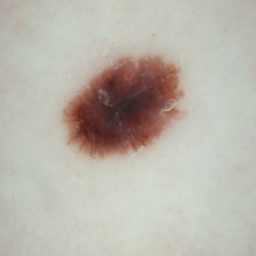

In [95]:
image

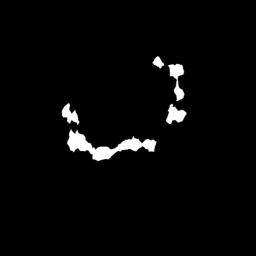

In [96]:
mask

In [104]:
import torch
from torch import nn
import torch.optim as optim

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'mps' if torch.backends.mps.is_available() else 'cpu'

model = Unet()

# Move model to the device
model = model.to(device)

# Set the loss function
criterion = nn.BCEWithLogitsLoss()

# Create the Adam optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Number of epochs
num_epochs = 10

# Training loop
for epoch in range(num_epochs):
    for i, batch in enumerate(streaks_train_dataloader):
        images, masks = batch['image'], batch['mask']

        # Move images and masks to the device
        images = images.to(device)
        masks = masks.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print loss value every 10 batches
        if (i+1) % 10 == 0:
            print (f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(streaks_train_dataloader)}], Loss: {loss.item()}")

Epoch [1/10], Step [10/25], Loss: 0.049692779779434204
Epoch [1/10], Step [20/25], Loss: 0.10454349219799042
Epoch [2/10], Step [10/25], Loss: 0.03150142356753349
Epoch [2/10], Step [20/25], Loss: 0.038679614663124084
Epoch [3/10], Step [10/25], Loss: 0.07762899994850159
Epoch [3/10], Step [20/25], Loss: 0.06423167884349823
Epoch [4/10], Step [10/25], Loss: 0.0604734942317009
Epoch [4/10], Step [20/25], Loss: 0.060421548783779144
Epoch [5/10], Step [10/25], Loss: 0.06020818650722504
Epoch [5/10], Step [20/25], Loss: 0.07673538476228714
Epoch [6/10], Step [10/25], Loss: 0.0803556889295578
Epoch [6/10], Step [20/25], Loss: 0.06192980334162712
Epoch [7/10], Step [10/25], Loss: 0.03615961968898773
Epoch [7/10], Step [20/25], Loss: 0.08683326840400696
Epoch [8/10], Step [10/25], Loss: 0.12857846915721893
Epoch [8/10], Step [20/25], Loss: 0.05027953162789345
Epoch [9/10], Step [10/25], Loss: 0.08575171232223511
Epoch [9/10], Step [20/25], Loss: 0.03999336063861847
Epoch [10/10], Step [10/25]

## More advanced training loop setup
With training on a specific class attribute dataset instead of full dataset like above

In [6]:
from datasets import load_dataset
import numpy as np

# Load the dataset
dataset = load_dataset("jtz18/skin-lesion", "task1")
dataset

/opt/conda/lib/python3.11/site-packages/datasets/load.py:1454: FutureWarning: The repository for jtz18/skin-lesion contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/jtz18/skin-lesion
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 1242
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 100
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 1000
    })
})

In [7]:
class OneClassDataset(torch.utils.data.Dataset):
    def __init__(self, dataset=None, split="train", transform=None):
        self.dataset = dataset
        self.split = split
        self.transform = transform

    def __len__(self):
        return len(self.dataset[self.split])

    def __getitem__(self, idx):
        sample = self.dataset[self.split][idx]
        image = sample['image']
        mask = sample['label']
        image = np.array(image.convert('RGB'))
        mask = np.array(mask.convert('L'), dtype=np.float32)
        mask[mask == 255.0] = 1.0

        if self.transform:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations['image']
            mask = augmentations['mask']

        return image, mask

In [8]:
import os
import torch
import torchvision
from torch.utils.data import DataLoader
import wandb

def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    filename = "my_checkpoint.pth.tar"
    torch.save(state, filename)

def load_checkpoint(checkpoint, model):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])

def get_loaders(
    batch_size,
    train_transform,
    val_transform,
    num_workers=4,
    pin_memory=True,
):
    train_ds = OneClassDataset(
        dataset=dataset,
        split="train",
        transform=train_transform,
    )

    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=True,
    )

    val_ds = OneClassDataset(
        dataset=dataset,
        split="validation",
        transform=val_transform,
    )

    val_loader = DataLoader(
        val_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=False,
    )

    test_ds = OneClassDataset(
        dataset=dataset,
        split="test",
        transform=val_transform,
    )

    test_loader = DataLoader(
        test_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=False,
    )

    return train_loader, val_loader, test_loader

def check_accuracy(loader, model, device="cuda"):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    iou_score = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device).unsqueeze(1)
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2 * (preds * y).sum()) / (
                (preds + y).sum() + 1e-8
            )
            iou_score += iou_pytorch(preds, y)  # Calculate IoU score for the batch

    pixel_accuracy = num_correct / num_pixels * 100
    print(f"dice_score: {dice_score}")
    dice_score = dice_score / len(loader)
    print(f"Got {num_correct}/{num_pixels} with acc {pixel_accuracy:.2f}")
    wandb.log({"Pixel Accuracy": pixel_accuracy})
    print(f"Dice score: {dice_score}")
    wandb.log({"Dice Score": dice_score})
    print(f"IoU score: {iou_score}")  # Print IoU score to the console
    wandb.log({"IoU Score": iou_score})
    model.train()

def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # Convert tensors to 'Bool' type
    outputs_int = outputs.int()
    labels_int = labels.int()

    intersection = (outputs_int & labels_int).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs_int | labels_int).float().sum((1, 2))  # Will be zero if both are 0

    iou = (intersection + 1e-6) / (union + 1e-6)  # We smooth our division to avoid 0/0

    return iou.mean()  # Average over the batch


def save_predictions_as_imgs(
    loader, model, folder="saved_images", device="cuda"
):

    # Create directory if it doesn't exist
    if not os.path.exists(folder):
        os.makedirs(folder)

    model.eval()
    for idx, (x, y) in enumerate(loader):
        x = x.to(device=device)
        with torch.no_grad():
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
            # print(f"pred_shape: {preds.shape}")
            # print(f"y_shape: {y.shape}")

        torchvision.utils.save_image(
            preds, f"{folder}/pred_{idx}.png"
        )
        torchvision.utils.save_image(y.unsqueeze(1), f"{folder}/{idx}.png")

    model.train()

In [9]:
# Hyperparameters etc.
import wandb

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

LEARNING_RATE = 1e-3

DEVICE = device
BATCH_SIZE = 8

NUM_EPOCHS = 1000

NUM_WORKERS = 2

IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256

PIN_MEMORY = True
LOAD_MODEL = False
CHECKPOINT_FILENAME = "None"   # Model checkpoint filename if LOAD is True
CLASS = "task1"
MODEL = "MALUNet"

# Initialize a new run
run = wandb.init(project="unet-skin-lesion", config={
    "learning_rate": LEARNING_RATE,
    "device": DEVICE,
    "batch_size": BATCH_SIZE,
    "num_epochs": NUM_EPOCHS,
    "num_workers": NUM_WORKERS,
    "image_height": IMAGE_HEIGHT,
    "image_width": IMAGE_WIDTH,
    "pin_memory": PIN_MEMORY,
    "load_model": LOAD_MODEL,
    "checkpoint_filename": CHECKPOINT_FILENAME,
    "class": CLASS,
    "model": MODEL
})

wandb: Currently logged in as: jtz18 (jooz-cave). Use `wandb login --relogin` to force relogin


In [10]:
from tqdm import tqdm
def train_fn(loader, model, optimizer, loss_fn, scaler):
    loop = tqdm(loader)

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=DEVICE)
        targets = targets.float().unsqueeze(1).to(device=DEVICE)

        # forward
        with torch.cuda.amp.autocast():
            predictions = model(data)
            loss = loss_fn(predictions, targets)
            wandb.log({"Training Loss": loss})

        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # update tqdm loop
        loop.set_postfix(loss=loss.item())

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2


train_transform = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Rotate(limit=35, p=1.0),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.1),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ],
)

val_transforms = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ],
)

# model = Unet(in_channels=3, out_channels=1).to(DEVICE)
model = MALUNet().to(DEVICE)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)


train_loader, val_loader, test_loader = get_loaders(
    BATCH_SIZE,
    train_transform,
    val_transforms,
    NUM_WORKERS,
    PIN_MEMORY,
)

if LOAD_MODEL:
    load_checkpoint(torch.load(CHECKPOINT_FILENAME), model)


check_accuracy(val_loader, model, device=DEVICE)
scaler = torch.cuda.amp.GradScaler()

for epoch in range(NUM_EPOCHS):
    train_fn(train_loader, model, optimizer, loss_fn, scaler)

    # save model
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer":optimizer.state_dict(),
        "epoch": epoch,
    }
    save_checkpoint(checkpoint, filename=f"checkpoint_{epoch}.pth.tar")

    # check accuracy
    check_accuracy(val_loader, model, device=DEVICE)

    # print some examples to a folder
    save_predictions_as_imgs(
        val_loader, model, folder=f"saved_images/{epoch}", device=DEVICE
    )

SC_Att_Bridge was used
dice_score: 5.346303939819336
Got 1760655/6553600 with acc 26.87
Dice score: 0.4112541675567627
IoU score: 3.440263271331787


100%|██████████| 156/156 [02:42<00:00,  1.04s/it, loss=0.63] 


=> Saving checkpoint
dice_score: 5.694303035736084
Got 2361589/6553600 with acc 36.03
Dice score: 0.43802332878112793
IoU score: 3.7619292736053467


100%|██████████| 156/156 [02:33<00:00,  1.02it/s, loss=0.631]


=> Saving checkpoint
dice_score: 5.853558540344238
Got 2602455/6553600 with acc 39.71
Dice score: 0.4502737522125244
IoU score: 3.8347911834716797


100%|██████████| 156/156 [02:30<00:00,  1.04it/s, loss=0.585]


=> Saving checkpoint
dice_score: 5.780799388885498
Got 2469803/6553600 with acc 37.69
Dice score: 0.4446769058704376
IoU score: 3.8519887924194336


100%|██████████| 156/156 [02:31<00:00,  1.03it/s, loss=0.656]


=> Saving checkpoint
dice_score: 6.0152997970581055
Got 2814529/6553600 with acc 42.95
Dice score: 0.46271538734436035
IoU score: 3.9569296836853027


100%|██████████| 156/156 [02:35<00:00,  1.00it/s, loss=0.688]


=> Saving checkpoint
dice_score: 6.057427883148193
Got 2864435/6553600 with acc 43.71
Dice score: 0.4659560024738312
IoU score: 3.9081501960754395


100%|██████████| 156/156 [02:30<00:00,  1.04it/s, loss=0.708]


=> Saving checkpoint
dice_score: 5.981679439544678
Got 2739929/6553600 with acc 41.81
Dice score: 0.4601292014122009
IoU score: 3.906081438064575


100%|██████████| 156/156 [02:40<00:00,  1.03s/it, loss=0.692]


=> Saving checkpoint
dice_score: 6.1681647300720215
Got 2994967/6553600 with acc 45.70
Dice score: 0.4744742214679718
IoU score: 3.9708144664764404


100%|██████████| 156/156 [02:39<00:00,  1.02s/it, loss=0.652]


=> Saving checkpoint
dice_score: 5.895998477935791
Got 2610997/6553600 with acc 39.84
Dice score: 0.45353835821151733
IoU score: 3.838045835494995


100%|██████████| 156/156 [02:41<00:00,  1.03s/it, loss=0.582]


=> Saving checkpoint
dice_score: 5.9344868659973145
Got 2667415/6553600 with acc 40.70
Dice score: 0.45649901032447815
IoU score: 3.8484890460968018


100%|██████████| 156/156 [02:33<00:00,  1.02it/s, loss=0.624]


=> Saving checkpoint
dice_score: 5.932861328125
Got 2642085/6553600 with acc 40.32
Dice score: 0.4563739597797394
IoU score: 3.861081123352051


100%|██████████| 156/156 [02:37<00:00,  1.01s/it, loss=0.655]


=> Saving checkpoint
dice_score: 5.962432861328125
Got 2682904/6553600 with acc 40.94
Dice score: 0.4586487114429474
IoU score: 3.8745462894439697


100%|██████████| 156/156 [02:38<00:00,  1.02s/it, loss=0.601]


=> Saving checkpoint
dice_score: 6.132758617401123
Got 2922405/6553600 with acc 44.59
Dice score: 0.4717506766319275
IoU score: 3.9458749294281006


100%|██████████| 156/156 [02:39<00:00,  1.02s/it, loss=0.589]


=> Saving checkpoint
dice_score: 6.060774803161621
Got 2801402/6553600 with acc 42.75
Dice score: 0.4662134647369385
IoU score: 3.8870365619659424


100%|██████████| 156/156 [02:40<00:00,  1.03s/it, loss=0.639]


=> Saving checkpoint
dice_score: 6.214846134185791
Got 3020478/6553600 with acc 46.09
Dice score: 0.4780651032924652
IoU score: 3.9621217250823975


100%|██████████| 156/156 [02:33<00:00,  1.02it/s, loss=0.68] 


=> Saving checkpoint
dice_score: 6.475934028625488
Got 3302420/6553600 with acc 50.39
Dice score: 0.4981487989425659
IoU score: 4.115118503570557


100%|██████████| 156/156 [02:34<00:00,  1.01it/s, loss=0.63] 


=> Saving checkpoint
dice_score: 5.999640941619873
Got 2719114/6553600 with acc 41.49
Dice score: 0.46151086688041687
IoU score: 3.862846612930298


100%|██████████| 156/156 [02:34<00:00,  1.01it/s, loss=0.657]


=> Saving checkpoint
dice_score: 6.438022613525391
Got 3261608/6553600 with acc 49.77
Dice score: 0.4952325224876404
IoU score: 4.073395252227783


100%|██████████| 156/156 [02:34<00:00,  1.01it/s, loss=0.58] 


=> Saving checkpoint
dice_score: 6.5321550369262695
Got 3331506/6553600 with acc 50.83
Dice score: 0.5024734735488892
IoU score: 4.098857879638672


100%|██████████| 156/156 [02:32<00:00,  1.02it/s, loss=0.607]


=> Saving checkpoint
dice_score: 6.471959590911865
Got 3290424/6553600 with acc 50.21
Dice score: 0.49784305691719055
IoU score: 4.062647819519043


100%|██████████| 156/156 [02:43<00:00,  1.05s/it, loss=0.644]


=> Saving checkpoint
dice_score: 6.486825466156006
Got 3273222/6553600 with acc 49.95
Dice score: 0.4989866018295288
IoU score: 4.198835849761963


100%|██████████| 156/156 [02:31<00:00,  1.03it/s, loss=0.649]


=> Saving checkpoint
dice_score: 7.002712249755859
Got 3794047/6553600 with acc 57.89
Dice score: 0.5386701822280884
IoU score: 4.402969837188721


100%|██████████| 156/156 [02:38<00:00,  1.01s/it, loss=0.656]


=> Saving checkpoint
dice_score: 6.159862995147705
Got 2894464/6553600 with acc 44.17
Dice score: 0.47383564710617065
IoU score: 3.902574062347412


100%|██████████| 156/156 [02:38<00:00,  1.02s/it, loss=0.585]


=> Saving checkpoint
dice_score: 6.771317481994629
Got 3565456/6553600 with acc 54.40
Dice score: 0.520870566368103
IoU score: 4.31122350692749


100%|██████████| 156/156 [02:29<00:00,  1.04it/s, loss=0.683]


=> Saving checkpoint
dice_score: 7.289477825164795
Got 4048197/6553600 with acc 61.77
Dice score: 0.5607290863990784
IoU score: 4.537423133850098


100%|██████████| 156/156 [02:34<00:00,  1.01it/s, loss=0.674]


=> Saving checkpoint
dice_score: 6.6259026527404785
Got 3410699/6553600 with acc 52.04
Dice score: 0.5096848607063293
IoU score: 4.2074480056762695


100%|██████████| 156/156 [02:35<00:00,  1.01it/s, loss=0.653]


=> Saving checkpoint
dice_score: 6.8706889152526855
Got 3672417/6553600 with acc 56.04
Dice score: 0.528514564037323
IoU score: 4.292210102081299


100%|██████████| 156/156 [02:49<00:00,  1.09s/it, loss=0.619]


=> Saving checkpoint
dice_score: 7.2100300788879395
Got 3970307/6553600 with acc 60.58
Dice score: 0.554617702960968
IoU score: 4.401196002960205


100%|██████████| 156/156 [02:33<00:00,  1.02it/s, loss=0.675]


=> Saving checkpoint
dice_score: 7.029622554779053
Got 3811487/6553600 with acc 58.16
Dice score: 0.5407401919364929
IoU score: 4.299639701843262


100%|██████████| 156/156 [02:30<00:00,  1.04it/s, loss=0.681]


=> Saving checkpoint
dice_score: 6.029050350189209
Got 2727275/6553600 with acc 41.61
Dice score: 0.46377313137054443
IoU score: 3.837174654006958


 17%|█▋        | 27/156 [00:26<02:08,  1.01it/s, loss=0.653]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

100%|██████████| 156/156 [02:35<00:00,  1.01it/s, loss=0.638]


=> Saving checkpoint
dice_score: 7.447805881500244
Got 4155246/6553600 with acc 63.40
Dice score: 0.5729081630706787
IoU score: 4.448403358459473


100%|██████████| 156/156 [02:32<00:00,  1.02it/s, loss=0.681]


=> Saving checkpoint
dice_score: 6.951318740844727
Got 3724554/6553600 with acc 56.83
Dice score: 0.5347168445587158
IoU score: 4.241620063781738


100%|██████████| 156/156 [02:28<00:00,  1.05it/s, loss=0.597]


=> Saving checkpoint
dice_score: 6.871482849121094
Got 3659024/6553600 with acc 55.83
Dice score: 0.528575599193573
IoU score: 4.334383010864258


100%|██████████| 156/156 [02:35<00:00,  1.01it/s, loss=0.684]


=> Saving checkpoint
dice_score: 6.874057292938232
Got 3673414/6553600 with acc 56.05
Dice score: 0.5287736654281616
IoU score: 4.279032230377197


100%|██████████| 156/156 [02:30<00:00,  1.04it/s, loss=0.595]


=> Saving checkpoint
dice_score: 6.582093238830566
Got 3375634/6553600 with acc 51.51
Dice score: 0.5063148736953735
IoU score: 4.056323528289795


100%|██████████| 156/156 [02:35<00:00,  1.00it/s, loss=0.656]


=> Saving checkpoint
dice_score: 7.309761047363281
Got 4044179/6553600 with acc 61.71
Dice score: 0.5622893571853638
IoU score: 4.496669292449951


100%|██████████| 156/156 [02:38<00:00,  1.02s/it, loss=0.653]


=> Saving checkpoint
dice_score: 7.662719249725342
Got 4333628/6553600 with acc 66.13
Dice score: 0.5894399881362915
IoU score: 4.57452917098999


100%|██████████| 156/156 [02:32<00:00,  1.02it/s, loss=0.584]


=> Saving checkpoint
dice_score: 6.9646196365356445
Got 3764280/6553600 with acc 57.44
Dice score: 0.5357400178909302
IoU score: 4.205731391906738


100%|██████████| 156/156 [02:27<00:00,  1.06it/s, loss=0.588]


=> Saving checkpoint
dice_score: 8.058258056640625
Got 4610255/6553600 with acc 70.35
Dice score: 0.6198660135269165
IoU score: 4.835207939147949


100%|██████████| 156/156 [02:30<00:00,  1.03it/s, loss=0.678]


=> Saving checkpoint
dice_score: 6.948192119598389
Got 3745449/6553600 with acc 57.15
Dice score: 0.5344763398170471
IoU score: 4.139375686645508


100%|██████████| 156/156 [02:34<00:00,  1.01it/s, loss=0.63] 


=> Saving checkpoint
dice_score: 8.757576942443848
Got 5039003/6553600 with acc 76.89
Dice score: 0.6736598014831543
IoU score: 4.8604416847229


100%|██████████| 156/156 [02:37<00:00,  1.01s/it, loss=0.633]


=> Saving checkpoint
dice_score: 6.908015251159668
Got 3681556/6553600 with acc 56.18
Dice score: 0.5313857793807983
IoU score: 4.3260016441345215


100%|██████████| 156/156 [02:28<00:00,  1.05it/s, loss=0.608]


=> Saving checkpoint
dice_score: 7.516485214233398
Got 4228580/6553600 with acc 64.52
Dice score: 0.5781912207603455
IoU score: 4.622973442077637


100%|██████████| 156/156 [02:32<00:00,  1.03it/s, loss=0.622]


=> Saving checkpoint
dice_score: 7.434700012207031
Got 4164360/6553600 with acc 63.54
Dice score: 0.5719000101089478
IoU score: 4.5653076171875


100%|██████████| 156/156 [02:34<00:00,  1.01it/s, loss=0.645]


=> Saving checkpoint
dice_score: 7.629242897033691
Got 4285447/6553600 with acc 65.39
Dice score: 0.5868648886680603
IoU score: 4.507689476013184


100%|██████████| 156/156 [02:32<00:00,  1.02it/s, loss=0.609]


=> Saving checkpoint
dice_score: 7.471406936645508
Got 4165256/6553600 with acc 63.56
Dice score: 0.5747236609458923
IoU score: 4.412320613861084


100%|██████████| 156/156 [02:30<00:00,  1.04it/s, loss=0.666]


=> Saving checkpoint
dice_score: 7.922171115875244
Got 4505595/6553600 with acc 68.75
Dice score: 0.609397828578949
IoU score: 4.595314979553223


100%|██████████| 156/156 [02:29<00:00,  1.04it/s, loss=0.637]


=> Saving checkpoint
dice_score: 8.20312213897705
Got 4696910/6553600 with acc 71.67
Dice score: 0.6310093998908997
IoU score: 4.802403926849365


100%|██████████| 156/156 [02:30<00:00,  1.04it/s, loss=0.64] 


=> Saving checkpoint
dice_score: 8.571701049804688
Got 4919371/6553600 with acc 75.06
Dice score: 0.6593616604804993
IoU score: 4.921981334686279


100%|██████████| 156/156 [02:33<00:00,  1.02it/s, loss=0.658]


=> Saving checkpoint
dice_score: 7.810111999511719
Got 4420637/6553600 with acc 67.45
Dice score: 0.6007778644561768
IoU score: 4.589587688446045


 83%|████████▎ | 130/156 [02:13<00:24,  1.07it/s, loss=0.617]

In [26]:
run.finish()

Dice Score,▁▁▁▁▁█▁█▁▁▁█▁▁▁▁▁▁▁
Pixel Accuracy,█████▁█▁███▁███████
Dice Score,0.0
Pixel Accuracy,99.49367
